In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mysql.connector as connector
%matplotlib inline

In [2]:
db = connector.connect(
    host = 'localhost',
    username = 'root',
    password = 'admin@2024',
    database = 'ecommerce'
)

In [3]:
cur = db.cursor()

### 1. List all unique cities where customers are located.

In [4]:
query = '''select distinct customer_city from customers'''
cur.execute(query)
data = cur.fetchall()
question1 = pd.DataFrame(data)
question1.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### 2. Count the number of orders placed in 2017.

In [5]:
query = '''select count(order_id) from orders where year(order_purchase_timestamp) = 2017'''
cur.execute(query)
data = cur.fetchall()
print('the number of orders placed in 2017 is ', data)

the number of orders placed in 2017 is  [(135303,)]


### 3. Find the total sales per category.

In [6]:
query = '''select upper(p.product_category), round(sum(pay.payment_value), 2)
from 
ecommerce.products p
inner join ecommerce.order_items oi
on 
p.product_id = oi.product_id
inner join 
ecommerce.payments pay
on pay.order_id = oi.order_id
group by p.product_category;'''
cur.execute(query)
data = cur.fetchall()
question3 = pd.DataFrame(data)
question3.columns = ['Product_catergory', 'Sales']
question3.head()

,Product_catergory,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66


### 4. Calculate the percentage of orders that were paid in installments.

In [7]:
query = '''select 
(count(order_id) / (select count(*) from ecommerce.payments))*100 as Percentage 
from 
ecommerce.payments 
where 
payment_installments >= 1;'''
cur.execute(query)
question4 = cur.fetchall()
print(question4)

[(Decimal('99.9981'),)]


### 1. Calculate the number of orders per month in 2018.

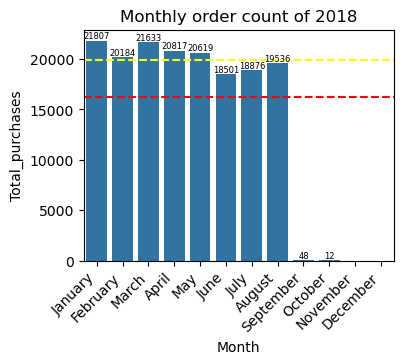

In [8]:
query = '''
select monthname(order_purchase_timestamp) as months, count(order_id)
from
ecommerce.orders
where year(order_purchase_timestamp) = 2018
group by monthname(order_purchase_timestamp); 
'''
cur.execute(query)
question5 = pd.DataFrame(cur.fetchall(), columns=['Month', 'Total_purchases'])
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
plt.figure(figsize = (4,3))
ax=sns.barplot(x = question5['Month'], y=question5['Total_purchases'],data = question5,  order=month_order)
ax.axhline(question5['Total_purchases'].mean(), ls = 'dashed', color = 'red', label ='mean order count')
ax.axhline(question5['Total_purchases'].median(), ls = 'dashed', color = 'yellow', label ='median order count')
ax.bar_label(ax.containers[0], fontsize=6)
plt.xticks(horizontalalignment = 'right', rotation = 45)
plt.title('Monthly order count of 2018')
plt.show()

### 2. Find the average number of products per order, grouped by customer city.

In [9]:
query = '''
with cte as 
(select oi.order_id, o.customer_id, count(oi.order_id) as order_count
from 
order_items oi inner join orders o
on oi.order_id = o.order_id
group by oi.order_id, o.customer_id)

select distinct(c.customer_city), round(avg(ct.order_count), 2) as order_count
from customers c
inner join
cte ct
on c.customer_id = ct.customer_id
group by c.customer_city
order by order_count desc;
'''
cur.execute(query)
data = cur.fetchall()
question6 = pd.DataFrame(data, columns=['customer_city', 'items_per_order'])

### 3. Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = '''select p.product_category, 
round((sum(pay.payment_value)/(select sum(payment_value) from payments))*100, 2)
as percentage_sum
from products p
inner join 
order_items oi
on p.product_id = oi.product_id
inner join
payments pay
on pay.order_id = oi.order_id
group by p.product_category
order by percentage_sum desc;'''
cur.execute(query)
question7 = pd.DataFrame(cur.fetchall(), columns = ['Product_Category', 'Percentage_contribution'])
question7.head()

,Product_Category,Percentage_contribution
0,bed table bath,21.40
1,HEALTH BEAUTY,20.71
2,computer accessories,19.81
3,Furniture Decoration,17.87
4,Watches present,17.86


### 4. Identify the correlation between product price and the number of times a product has been purchased.


In [11]:
query = '''
select p.product_category, round(avg(oi.price), 2), count(oi.product_id)
from 
order_items oi
inner join 
products p
on 
p.product_id = oi.product_id
group by p.product_category;
'''
cur.execute(query)
question8 = pd.DataFrame(cur.fetchall(), columns=['product_category', 'Average_price', 'Count'])
corr_index = np.corrcoef(question8['Average_price'], question8['Count'])[0][1]
print('the correlation index = ', corr_index)

the correlation index =  -0.10631514167157562


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

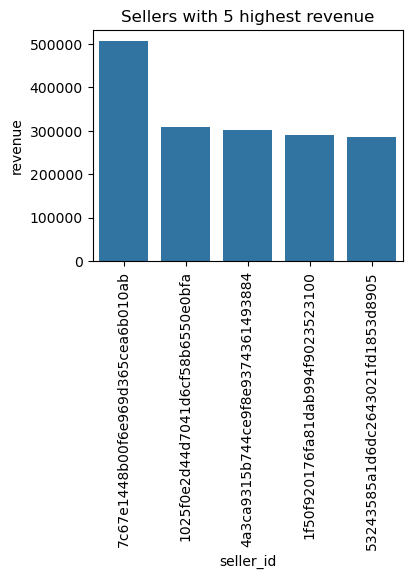

In [12]:
query = '''
select *, dense_rank() over(order by revenue desc ) as 'rank' from
(select oi.seller_id, sum(p.payment_value) as revenue
from 
order_items oi
inner join
payments p
on oi.order_id = p.order_id
group by oi.seller_id) as derived_table;
'''
cur.execute(query)
data = cur.fetchall()
question10 = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = question10.head()
plt.figure(figsize=[4,3])
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.title('Sellers with 5 highest revenue')
plt.xticks(rotation = 90)
plt.show()

### 1. Calculate the moving average of order values for each customer over their order history.

CPU times: total: 0 ns
Wall time: 0 ns


<Axes: >

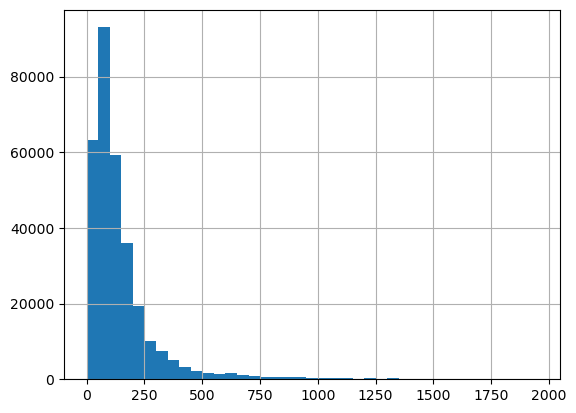

In [13]:
%time
query = '''
select o.customer_id,
timestamp(o.order_purchase_timestamp),
avg(p.payment_value) 
over(partition by o.customer_id order by o.order_purchase_timestamp rows between 2 preceding and current row) as running_bill
from orders o
inner join 
payments p
on 
o.order_id = p.order_id;
'''
cur.execute(query)
question11 = pd.DataFrame(cur.fetchall(), columns = ['customer_id', 'purchase_timestamp', 'running_bill'])
question11['running_bill'].hist(bins = range(0, 2000, 50))

### 2. Calculate the cumulative sales per month for each year.

In [14]:
query = '''
select year, month, total_value as yearly_value, 
sum(total_value) over(order by year, month) as cumulative_order_value
from
(select year(date(o.order_purchase_timestamp)) as 'year',
month(date(o.order_purchase_timestamp)) as 'month',
round(sum(p.payment_value)) as total_value
from 
ecommerce.orders o
inner join
ecommerce.payments p
on
o.order_id = p.order_id
group by year(date(o.order_purchase_timestamp)), month(date(o.order_purchase_timestamp))
order by year(date(o.order_purchase_timestamp)), month(date(o.order_purchase_timestamp))) as derived_table;
'''
cur.execute(query)
question12 = pd.DataFrame(cur.fetchall())
question12

,0,1,2,3
0,2016,9,757.0,757.0
1,2016,10,177271.0,178028.0
2,2016,12,59.0,178087.0
3,2017,1,415464.0,593551.0
4,2017,2,875724.0,1469275.0
5,2017,3,1349591.0,2818866.0
6,2017,4,1253364.0,4072230.0
7,2017,5,1778756.0,5850986.0
8,2017,6,1533829.0,7384815.0
9,2017,7,1777149.0,9161964.0


### 3. Calculate the year-over-year growth rate of total sales.

In [16]:
query = '''
select year, total_value, coalesce(round((total_value/ lag_total)*100, 2),0)
from
(select year(date(o.order_purchase_timestamp)) as 'year',
round(sum(p.payment_value)) as total_value,
coalesce(lag(round(sum(p.payment_value))) over(order by year(date(o.order_purchase_timestamp))), 0) as lag_total
from 
ecommerce.orders o
inner join
ecommerce.payments p
on
o.order_id = p.order_id
group by year(date(o.order_purchase_timestamp)) 
order by year(date(o.order_purchase_timestamp))) as derived_table;
'''
cur.execute(query)
question13 = pd.DataFrame(cur.fetchall(), columns=['year', 'Yearly_cummulative_sum', 'percentage_increase'])
question13

,year,Yearly_cummulative_sum,percentage_increase
0,2016,178087.0,0.00
1,2017,21749240.0,12212.71
2,2018,26099289.0,120.00


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [18]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp > 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
question14 = cur.fetchall()
question14

[(None,)]

### 5. Identify the top 3 customers who spent the most money in each year.

AttributeError: Rectangle.set() got an unexpected keyword argument 'annotate'

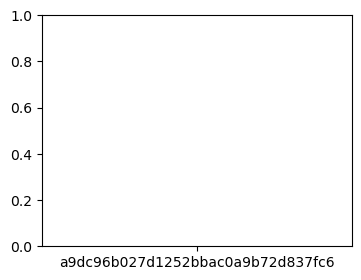

In [27]:
query = """
select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
plt.figure(figsize=[4,3])
ax = sns.barplot(x = "id", y = "payment", data = df, hue = "years", annotate = True)
plt.xticks(rotation = 90, fontsize=6)
plt.show()

In [26]:
type(ax.containers[0])

matplotlib.container.BarContainer